In [36]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import ( DensityMatrix, Kraus, state_fidelity, concurrence )


In [23]:
#Circuit

def advanced_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.h(1)
    qc.cx(0,1)
    qc.cp(np.pi/3, 1, 0)
    qc.h(0)
    return qc

advanced_circuit().draw('text')

┌───┐              ┌───┐
q_0: ┤ H ├──■───■───────┤ H ├
     ├───┤┌─┴─┐ │P(π/3) └───┘
q_1: ┤ H ├┤ X ├─■────────────
     └───┘└───┘

In [24]:
#define the decaying probabilities

def p_of_t(t, gamma = 0.6):
    return 1 - np.exp(-gamma * t)

#Defining the Kraus operator based noisy channel
def dynamical_pauli_channel(t, gamma = 0.6):
    p = p_of_t(t, gamma)
    K0 = np.sqrt(1 - p) * np.eye(2)
    K1 = np.sqrt(p/3) * np.array([[0,1],[1,0]])
    K2 = np.sqrt(p/3) * np.array([[0,-1j],[1j,0]])
    K3 = np.sqrt(p/3) * np.array([[1,0],[0,-1]])
    return Kraus([K0, K1, K2, K3])

#ideal state
qc_ideal = advanced_circuit()
rho_ideal = DensityMatrix.from_instruction(qc_ideal)

backend = Aer.get_backend("aer_simulator_density_matrix")

ts = np.linspace(0,3,20)
fidelities = []
entanglements = []

In [30]:
for  t in ts:
    #Theoretical simulation data points
    single_channel = dynamical_pauli_channel(t)
    two_qubit_channnel = single_channel.tensor(single_channel)
    rho_theory = rho_ideal.evolve(two_qubit_channnel)


    #circuit simulation
    qc_noisy = advanced_circuit()
    qc_noisy.save_density_matrix()

    p = p_of_t(t)
    error_1q = depolarizing_error(p,1)
    error_2q = depolarizing_error(p,2)
    
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error( error_1q, ['h'])
    noise_model.add_all_qubit_quantum_error( error_2q, ['cx','cp'])

    result = backend.run(qc_noisy, noise_model = noise_model).result()
    rho_sim = DensityMatrix(result.data(0)['density_matrix'])

    fidelities.append(state_fidelity(rho_theory, rho_sim))
    entanglements.append(concurrence(rho_sim))

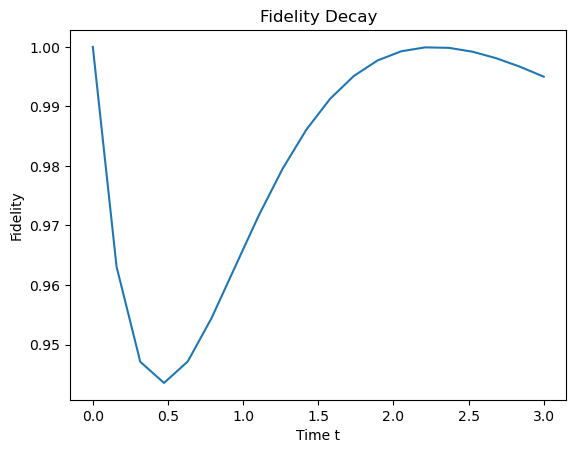

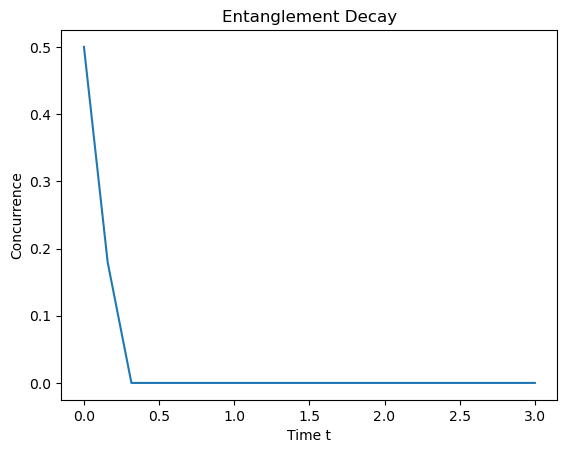

In [48]:
import matplotlib.pyplot as plt

plt.plot(ts, fidelities[3:])
plt.xlabel("Time t")
plt.ylabel("Fidelity")
plt.title("Fidelity Decay")
plt.show()

plt.plot(ts, entanglements[2:])
plt.xlabel("Time t")
plt.ylabel("Concurrence")
plt.title("Entanglement Decay")
plt.show()